In [81]:
import itertools
import re
from collections import Counter
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mlxtend.feature_selection import ColumnSelector
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.experimental import enable_halving_search_cv
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns


%matplotlib inline

In [82]:
source_path = "../data/ml-latest-small"

# Обработка данных

### Обработка movies.csv

In [83]:
movies_df = pd.read_csv(f"{source_path}/movies.csv")
movies_df.sample(5)

,movieId,title,genres
3679,5068,Beijing Bicycle (Shiqi sui de dan che) (2001),Drama
8246,104419,Justice League: Crisis on Two Earths (2010),Action|Animation|Sci-Fi
961,1262,"Great Escape, The (1963)",Action|Adventure|Drama|War
787,1030,Pete's Dragon (1977),Adventure|Animation|Children|Musical
6304,48262,"Bridge, The (2006)",Documentary


In [84]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [85]:
movies_df.rename({
    "movieId": "movie_id"
}, axis=1, inplace=True)

In [86]:
movies_df["genres"].replace("(no genres listed)", None, regex=False, inplace=True)
movies_df.dropna(inplace=True)

PATTERN_YEAR = re.compile(r"\((\d{4})\)$")

movies_df["year"] = movies_df["title"].str.strip().str.extract(PATTERN_YEAR)
movies_df["year"] = movies_df["year"].fillna(movies_df["year"].median()).astype("int16")

movies_df.drop("title", axis=1, inplace=True)

movies_df.sample(5)

,movie_id,genres,year
9521,171763,Action|Crime|Thriller,2017
1421,1944,Drama|Romance|War,1953
7129,71211,Comedy|Crime|Drama|Thriller,2009
7783,91842,Action|Crime|Drama|Thriller,2012
8508,114044,Horror,2014


In [87]:
cv = CountVectorizer(token_pattern="[a-z\-]+", binary=True, dtype="int8")
genres_vectors = cv.fit_transform(movies_df["genres"])
genres_list = cv.get_feature_names_out()
movies_df = pd.concat([
    movies_df.reset_index(drop=True).drop("genres", axis=1),
    pd.DataFrame(genres_vectors.todense(), columns=genres_list)
], axis=1)
movies_df.head(5)

,movie_id,year,action,adventure,animation,children,comedy,crime,documentary,drama,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,1,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9708 entries, 0 to 9707
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   movie_id     9708 non-null   int64
 1   year         9708 non-null   int16
 2   action       9708 non-null   int8 
 3   adventure    9708 non-null   int8 
 4   animation    9708 non-null   int8 
 5   children     9708 non-null   int8 
 6   comedy       9708 non-null   int8 
 7   crime        9708 non-null   int8 
 8   documentary  9708 non-null   int8 
 9   drama        9708 non-null   int8 
 10  fantasy      9708 non-null   int8 
 11  film-noir    9708 non-null   int8 
 12  horror       9708 non-null   int8 
 13  imax         9708 non-null   int8 
 14  musical      9708 non-null   int8 
 15  mystery      9708 non-null   int8 
 16  romance      9708 non-null   int8 
 17  sci-fi       9708 non-null   int8 
 18  thriller     9708 non-null   int8 
 19  war          9708 non-null   int8 
 20  western 

### Обработка tags.csv

In [90]:
tags_df = pd.read_csv(f"{source_path}/tags.csv")
tags_df.sample(5)

,userId,movieId,tag,timestamp
1090,474,345,men in drag,1138040381
2831,537,79132,complicated,1424140133
3043,567,6214,dark,1525283391
2778,513,750,Slim Pickens,1159980456
1586,474,2194,gangsters,1138032218


In [91]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [92]:
tags_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)
tags_df.drop("timestamp", axis=1, inplace=True)
tags_df.sample(5)

,user_id,movie_id,tag
594,318,68954,computer animation
1916,474,4447,lawyers
3130,567,57502,dark
3429,599,296,diner
2465,474,37729,06 Oscar Nominated Best Movie - Animation


In [93]:
PATTERN_CAPS = re.compile(r"[A-Z]+( [A-Z]+)+")
PATTERN_NETFLIX = re.compile(r"^in netflix queue$", flags=re.I)
PATTERN_BASED = re.compile(r"^based on a .*", flags=re.I)
PATTERN_ACTOR = re.compile(r"^[A-Z][A-Za-z]+( [A-Z][A-Za-z]+)+$")

tags_df["tag"] = tags_df["tag"].str.strip()
tags_df["tag"].replace("[\.\(\)( - )]", "", regex=True, inplace=True)
tags_df["tag"] = tags_df["tag"].str.replace("/", " ", regex=False)
mask_caps = tags_df["tag"].str.match(PATTERN_CAPS)
tags_df.loc[mask_caps, "tag"] = tags_df.loc[mask_caps, "tag"].str.lower()
mask_phrase = (tags_df["tag"].str.match(PATTERN_BASED) |
               tags_df["tag"].str.match(PATTERN_ACTOR) |
               tags_df["tag"].str.match(PATTERN_NETFLIX))
tags_df.loc[mask_phrase, "tag"] = tags_df.loc[mask_phrase, "tag"].str.replace(" ", "-")
mask_len = tags_df["tag"].map(lambda t: len(t) == 1)
tags_df.loc[mask_len, "tag"] = None
tags_df["tag"] = tags_df["tag"].str.lower()

tags_df = tags_df.groupby(["user_id", "movie_id"], as_index=False).agg(" ".join)
tags_df.sample(5)

,user_id,movie_id,tag
494,474,943,ghosts
574,474,1210,darthvader lukeskywalker spaceopera
1397,474,8197,innetflixqueue
605,474,1257,skiing
420,474,588,disney


In [94]:
cv = CountVectorizer(
    token_pattern="[\da-z\-]+", stop_words="english",
    max_features=500, min_df=5, max_df=0.7,
    binary=True, dtype="int8"
)
tags_vectors = cv.fit_transform(tags_df["tag"])
tags_list = cv.get_feature_names_out()
tags_df = pd.concat([
    tags_df.reset_index(drop=True).drop("tag", axis=1),
    pd.DataFrame(tags_vectors.todense(), columns=tags_list)
], axis=1)
tags_df.sample(5)

,user_id,movie_id,aardman,action,adamsandler,adolescence,adultery,adventure,africa,alcoholism,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
1415,474,8463,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,474,947,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
735,474,1961,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,125,3052,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1054,474,4347,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

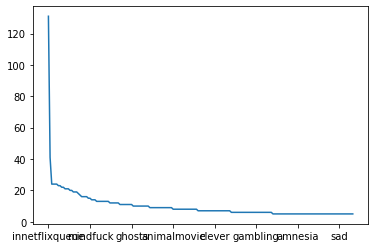

In [95]:
tags_df.drop(["user_id", "movie_id"], axis=1).sum().sort_values(ascending=False).plot()

In [96]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Columns: 186 entries, user_id to zombies
dtypes: int64(2), int8(184)
memory usage: 346.8 KB


### Обработка ratings.csv

In [98]:
ratings_df = pd.read_csv(f"{source_path}/ratings.csv")
ratings_df.sample(5)

,userId,movieId,rating,timestamp
26438,182,2135,1.5,1063285520
37970,259,6711,5.0,1146845498
71051,453,3300,4.0,972622055
92420,597,1982,5.0,941640505
76678,480,4447,3.0,1179165265


In [99]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [100]:
ratings_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)
ratings_df.drop("timestamp", axis=1, inplace=True)
ratings_df["rating"] = ratings_df["rating"].astype("int8")
ratings_df.sample(5)

,user_id,movie_id,rating
7816,52,31696,4
40090,274,6868,4
23930,166,1784,3
71861,462,8865,2
33757,230,589,0


In [101]:
ratings_df["rating_binary"] = (ratings_df["rating"] >= 4).astype("int8")
ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary
85783,555,3421,4,1
50403,325,3623,3,0
26887,182,5325,3,0
18184,115,1240,5,1
55086,365,96737,1,0


In [102]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   user_id        100836 non-null  int64
 1   movie_id       100836 non-null  int64
 2   rating         100836 non-null  int8 
 3   rating_binary  100836 non-null  int8 
dtypes: int64(2), int8(2)
memory usage: 1.7 MB


# Подготовка данных для моделей

### Модель жанров

In [103]:
movies_ratings_df = pd.merge(
    ratings_df,
    movies_df,
    on="movie_id"
)

movies_ratings_df["views_count"] = movies_ratings_df.groupby('movie_id')["user_id"].transform('count')
movies_ratings_df["rating_mean"] = movies_ratings_df.groupby('movie_id')["rating"].transform('mean')

movies_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,year,action,adventure,animation,children,comedy,...,imax,musical,mystery,romance,sci-fi,thriller,war,western,views_count,rating_mean
64660,367,2430,4,1,1949,0,1,0,1,0,...,0,0,0,0,0,0,0,0,6,2.833333
81747,318,27904,4,1,2006,0,0,1,0,0,...,0,0,1,0,1,1,0,0,22,3.409091
17524,295,79132,5,1,2010,1,0,0,0,0,...,1,0,1,0,1,1,0,0,143,3.888112
64999,484,3988,4,1,2000,0,0,0,1,1,...,0,0,0,0,0,0,0,0,33,2.848485
60612,294,2003,4,1,1984,0,0,0,0,1,...,0,0,0,0,0,0,0,0,41,3.243902


In [104]:
users_genres_df = pd.concat([
    movies_ratings_df["user_id"].copy(),
    movies_ratings_df[genres_list].mul(movies_ratings_df["rating"], axis=0)
], axis=1)

users_genres_df = users_genres_df.groupby("user_id")[genres_list].mean()

users_genres_df.sample(5)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
user_id,,,,,,,,,,,,,,,,,,,
236,0.500000,0.333333,0.000000,0.000000,2.300000,0.466667,0.000000,0.733333,0.433333,0.000000,1.400000,0.000000,0.133333,0.433333,0.433333,0.366667,0.900000,0.000000,0.000000
229,1.138462,0.753846,0.138462,0.307692,1.553846,0.815385,0.000000,1.692308,0.323077,0.000000,0.107692,0.138462,0.061538,0.061538,0.769231,0.276923,1.261538,0.200000,0.046154
497,0.705882,0.627451,0.235294,0.254902,0.725490,0.823529,0.000000,2.235294,0.392157,0.000000,0.254902,0.215686,0.078431,0.470588,0.647059,0.529412,0.882353,0.313725,0.000000
157,0.809524,1.000000,0.190476,0.571429,2.000000,0.619048,0.000000,1.571429,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.238095,0.285714,0.619048,0.238095,0.000000
514,0.794937,0.620253,0.227848,0.316456,1.182278,0.412658,0.043038,1.177215,0.387342,0.020253,0.577215,0.111392,0.177215,0.217722,0.397468,0.559494,0.734177,0.088608,0.058228


In [105]:
genres_model_df = pd.merge(
    movies_ratings_df[ ["user_id", "movie_id", "year", "rating", "rating_mean", "views_count"]],
    users_genres_df,
    on="user_id",
)

genres_model_df["rating_binary"] = (genres_model_df["rating"] >= 4).astype("int8")
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
33212,381,2,1995,4,3.281818,110,0.951477,1.240506,0.533755,0.647679,...,0.162447,0.200422,0.251055,0.215190,0.670886,0.613924,0.759494,0.080169,0.031646,1
5706,68,485,1993,2,2.792453,53,0.990476,0.737302,0.196032,0.242857,...,0.212698,0.165079,0.118254,0.189683,0.710317,0.477778,0.788889,0.121429,0.054762,0
63443,610,2976,1999,4,3.333333,6,1.344854,0.715054,0.187404,0.147465,...,0.766513,0.211214,0.039171,0.327189,0.322581,0.665131,1.317204,0.128264,0.089862,1
11683,156,1265,1993,5,3.818182,143,0.381910,0.427136,0.087940,0.175879,...,0.047739,0.010050,0.183417,0.351759,0.929648,0.198492,0.572864,0.271357,0.055276,1
82774,489,42004,2005,3,3.166667,6,0.734568,0.641975,0.183642,0.208333,...,0.228395,0.134259,0.180556,0.206790,0.822531,0.398148,0.663580,0.121914,0.044753,0


In [106]:
genres_model_df.isna().sum()

user_id          0
movie_id         0
year             0
rating           0
rating_mean      0
views_count      0
action           0
adventure        0
animation        0
children         0
comedy           0
crime            0
documentary      0
drama            0
fantasy          0
film-noir        0
horror           0
imax             0
musical          0
mystery          0
romance          0
sci-fi           0
thriller         0
war              0
western          0
rating_binary    0
dtype: int64

In [107]:
genres_model_df.dropna(axis=1, how="all", inplace=True)
genres_model_df.fillna(genres_model_df.median(), inplace=True)
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
73458,386,442,1993,3,2.975309,81,1.338235,0.720588,0.044118,0.147059,...,0.235294,0.000000,0.044118,0.294118,0.220588,0.529412,1.382353,0.088235,0.205882,0
21145,249,2167,1998,4,3.206897,58,1.524857,0.941683,0.250478,0.224665,...,0.290631,0.340344,0.076482,0.304015,0.380497,0.795411,1.170172,0.130975,0.057361,1
41159,453,1457,1997,3,2.833333,12,1.138264,0.729904,0.173633,0.167203,...,0.144695,0.028939,0.090032,0.295820,0.816720,0.482315,1.099678,0.218650,0.045016,0
80389,387,933,1955,4,4.173913,23,0.588121,0.525803,0.149951,0.150925,...,0.417722,0.021422,0.115871,0.383642,0.434275,0.377799,0.932814,0.129503,0.066212,1
69100,105,109374,2014,4,3.615385,52,0.853964,0.730181,0.616134,0.339360,...,0.162726,0.172462,0.072323,0.396384,0.663421,0.495132,0.794159,0.237830,0.036161,1


In [108]:
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100789 entries, 0 to 100788
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        100789 non-null  int64  
 1   movie_id       100789 non-null  int64  
 2   year           100789 non-null  int16  
 3   rating         100789 non-null  int8   
 4   rating_mean    100789 non-null  float64
 5   views_count    100789 non-null  int64  
 6   action         100789 non-null  float64
 7   adventure      100789 non-null  float64
 8   animation      100789 non-null  float64
 9   children       100789 non-null  float64
 10  comedy         100789 non-null  float64
 11  crime          100789 non-null  float64
 12  documentary    100789 non-null  float64
 13  drama          100789 non-null  float64
 14  fantasy        100789 non-null  float64
 15  film-noir      100789 non-null  float64
 16  horror         100789 non-null  float64
 17  imax           100789 non-nul

In [109]:
dtypes_df = genres_model_df.select_dtypes(["float64", "float32"])
genres_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100789 entries, 0 to 100788
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        100789 non-null  int64  
 1   movie_id       100789 non-null  int64  
 2   year           100789 non-null  int16  
 3   rating         100789 non-null  int8   
 4   rating_mean    100789 non-null  float16
 5   views_count    100789 non-null  int64  
 6   action         100789 non-null  float16
 7   adventure      100789 non-null  float16
 8   animation      100789 non-null  float16
 9   children       100789 non-null  float16
 10  comedy         100789 non-null  float16
 11  crime          100789 non-null  float16
 12  documentary    100789 non-null  float16
 13  drama          100789 non-null  float16
 14  fantasy        100789 non-null  float16
 15  film-noir      100789 non-null  float16
 16  horror         100789 non-null  float16
 17  imax           100789 non-nul

In [111]:
genres_model_df[["year", "rating", "rating_mean", "views_count"]].describe()

,year,rating,rating_mean,views_count
count,100789.000000,100789.000000,100789.000000,100789.000000
mean,1994.440643,3.350872,NaN,58.782159
std,14.358357,1.089178,0.000000,61.969076
min,1902.000000,0.000000,0.000000,1.000000
25%,1990.000000,3.000000,3.000000,13.000000
50%,1997.000000,3.000000,3.435547,39.000000
75%,2003.000000,4.000000,3.759766,84.000000
max,2018.000000,5.000000,5.000000,329.000000


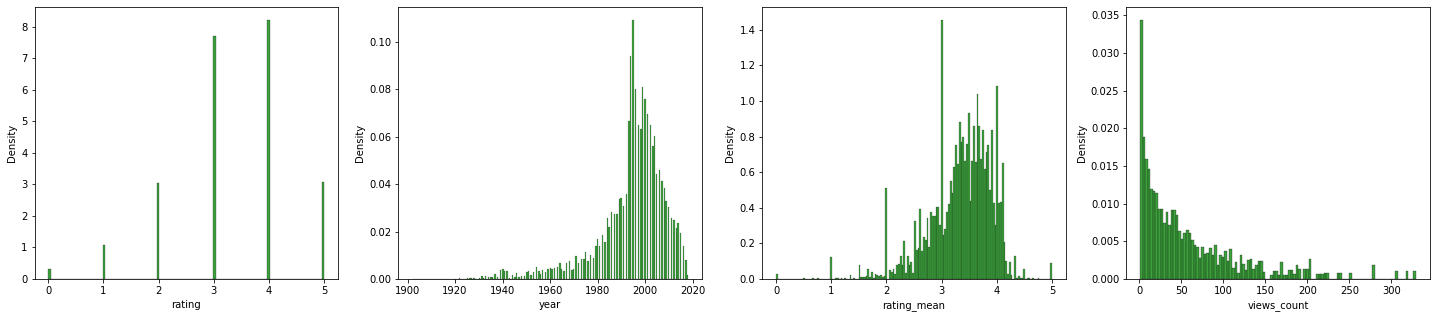

In [112]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

for i, feature in enumerate(genres_model_df[["rating", "year", "rating_mean", "views_count"]]):
    sns.histplot(genres_model_df[feature], color="green", stat="density", ax=ax[i])

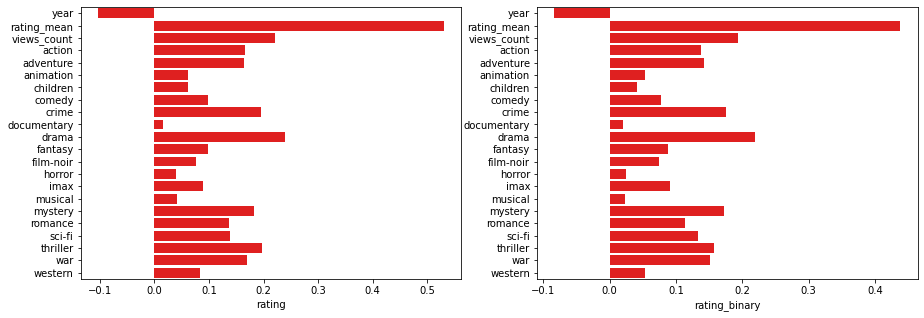

In [113]:
corr = genres_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

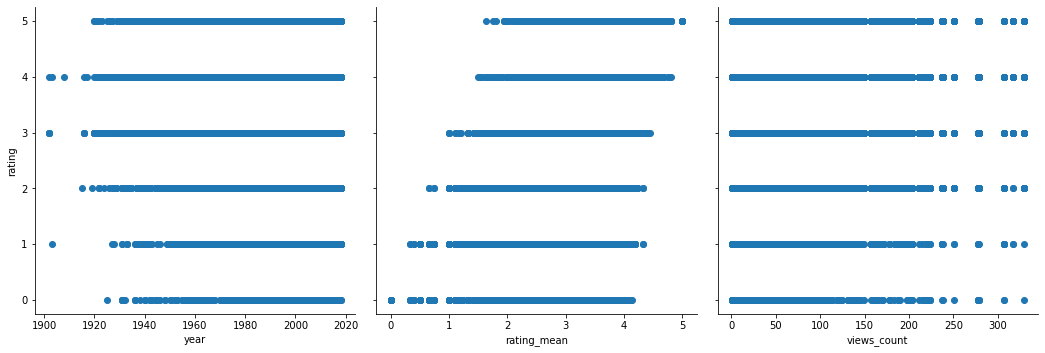

In [114]:
pg = sns.PairGrid(
    genres_model_df,
    x_vars=["year", "rating_mean", "views_count"],
    y_vars="rating",
    height=5,
)

pg.map(plt.scatter)

### Модель тэгов

In [115]:
tags_ratings_df = pd.merge(
    ratings_df.set_index(["user_id", "movie_id"]),
    tags_df.set_index(["user_id", "movie_id"]),
    on=["user_id", "movie_id"]
).reset_index()

tags_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,aardman,action,adamsandler,adolescence,adultery,adventure,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
863,474,3147,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,62,184471,3,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1474,477,79702,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1096,474,5994,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
813,474,2761,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
users_tags_df = pd.concat([
    tags_ratings_df["user_id"].copy(),
    tags_ratings_df[tags_list].mul(tags_ratings_df["rating"], axis=0)
], axis=1)
users_tags_df.replace(0, None, inplace=True)

users_tags_df = users_tags_df.groupby("user_id")[tags_list].mean()
users_tags_df.sample(5)

,aardman,action,adamsandler,adolescence,adultery,adventure,africa,alcoholism,aliens,alpacino,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
user_id,,,,,,,,,,,,,,,,,,,,,
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
184,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.538462,3.333333,NaN,NaN,3.0,NaN,NaN,NaN
439,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
tags_model_df = pd.merge(
    tags_ratings_df[["user_id", "movie_id", "rating", "rating_binary"]],
    users_tags_df,
    on="user_id"
)

tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,aardman,action,adamsandler,adolescence,adultery,adventure,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
1597,567,143367,4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.538462,3.333333,NaN,NaN,3.0,NaN,NaN,NaN
292,474,101,3,0,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5
1095,474,5991,4,1,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5
321,474,260,4,1,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5
854,474,3097,4,1,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5


In [118]:
tags_model_df.isna().sum()

user_id             0
movie_id            0
rating              0
rating_binary       0
aardman           486
                 ... 
willferrell      1505
witty            1328
wizards           486
worldwarii        411
zombies           412
Length: 188, dtype: int64

In [119]:
tags_model_df.dropna(axis=1, how="all", inplace=True)
tags_model_df.fillna(tags_model_df.median(), inplace=True)
tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,aardman,action,adamsandler,adolescence,adultery,adventure,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
62,62,111743,3,0,3.8,3.8,4.0,3.818182,3.545455,3.5,...,3.3,3.75,4.000000,4.000000,3.0,3.75,3.5,4.5,4.0,3.5
1559,567,74791,3,0,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,3.333333,3.0,3.75,3.0,4.5,3.0,3.5
1518,567,1921,3,0,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,3.333333,3.0,3.75,3.0,4.5,3.0,3.5
238,424,8950,4,1,3.8,2.0,4.0,3.818182,3.545455,4.0,...,3.3,3.75,2.000000,4.000000,3.0,3.75,3.0,4.5,3.0,3.5
1291,474,7981,4,1,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,4.000000,3.0,3.75,3.0,4.5,3.0,3.5


In [120]:
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635 entries, 0 to 1634
Columns: 188 entries, user_id to zombies
dtypes: float64(184), int64(2), int8(2)
memory usage: 2.3 MB


In [121]:
dtypes_df = tags_model_df.select_dtypes(["float64", "float32"])
tags_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635 entries, 0 to 1634
Columns: 188 entries, user_id to zombies
dtypes: float16(184), int64(2), int8(2)
memory usage: 629.1 KB


<AxesSubplot:xlabel='rating', ylabel='Density'>

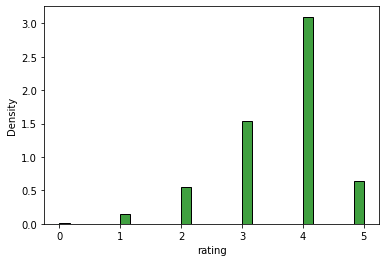

In [123]:
sns.histplot(tags_model_df["rating"], color="green", stat="density")

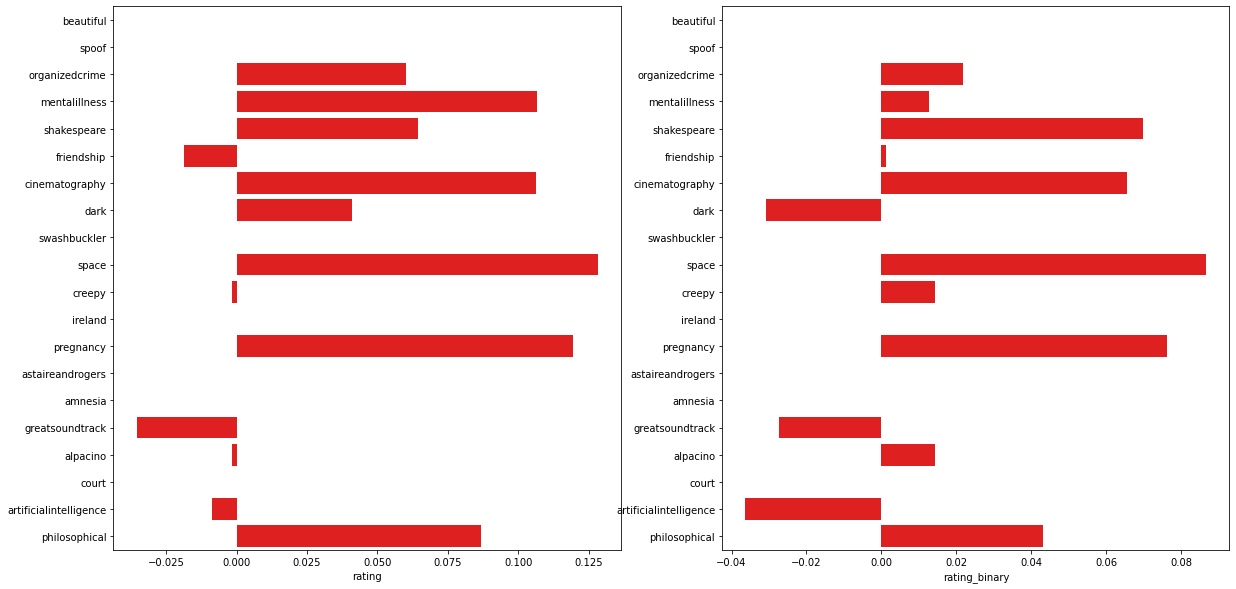

In [124]:
corr = tags_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"]).sample(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

## Финальная модель

In [125]:
genres_model_renamed_df = genres_model_df.add_suffix("_genres")
tags_model_renamed_df = tags_model_df.add_suffix("_tags")

final_model_df = pd.merge(
    genres_model_renamed_df.set_index(["user_id_genres", "movie_id_genres"]),
    tags_model_renamed_df.set_index(["user_id_tags", "movie_id_tags"]),
    left_on=["user_id_genres", "movie_id_genres"],
    right_on=["user_id_tags", "movie_id_tags"],
)
final_model_df.sample(5)

,year_genres,rating_genres,rating_mean_genres,views_count_genres,action_genres,adventure_genres,animation_genres,children_genres,comedy_genres,crime_genres,...,vietnam_tags,violence_tags,visuallyappealing_tags,visuallystunning_tags,wedding_tags,willferrell_tags,witty_tags,wizards_tags,worldwarii_tags,zombies_tags
1104,1970,2,3.000000,2,0.325928,0.401855,0.126221,0.190674,1.085938,0.375732,...,3.300781,3.75,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5
323,1993,2,3.324219,34,0.325928,0.401855,0.126221,0.190674,1.085938,0.375732,...,3.300781,3.75,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5
1418,1990,5,3.244141,45,1.732422,1.375000,0.123962,0.225952,0.919922,0.746582,...,3.300781,3.75,4.000000,4.0,3.0,3.75,3.5,4.5,4.0,3.5
253,2000,4,3.669922,94,0.325928,0.401855,0.126221,0.190674,1.085938,0.375732,...,3.300781,3.75,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5
1489,1989,4,4.000000,1,0.831055,0.685059,0.362549,0.265625,1.108398,0.547363,...,3.300781,3.75,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5


In [126]:
final_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1634 entries, 0 to 1633
Columns: 210 entries, year_genres to zombies_tags
dtypes: float16(204), int16(1), int64(1), int8(4)
memory usage: 686.2 KB


# Моделирование

In [127]:
def display_report(y_test: np.ndarray, y_pred: np.ndarray):
    class_names = set(y_test)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)

    sns.heatmap(pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred)),
        annot=True)
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()

    print(metrics.classification_report(y_test, y_pred, zero_division=0))

## Мультиклассовые модели

### Модель жанров

In [50]:
x = genres_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = genres_model_df.drop("user_id", axis=1)["rating"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler())
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [49]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 110
max_resources_: 80631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1000
n_resources: 110
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
----------
iter: 1
n_candidates: 334
n_resources: 330
Fitting 5 folds for each of 334 candidates, totalling 1670 fits
----------
iter: 2
n_candidates: 112
n_resources: 990
Fitting 5 folds for each of 112 candidates, totalling 560 fits
----------
iter: 3
n_candidates: 38
n_resources: 2970
Fitting 5 folds for each of 38 candidates, totalling 190 fits
----------
iter: 4
n_candidates: 13
n_resources: 8910
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 5
n_candidates: 5
n_resources: 26730
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 6
n_candidates: 2
n_resources: 80190
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'var_smoothing': 2.112112112900901} 0

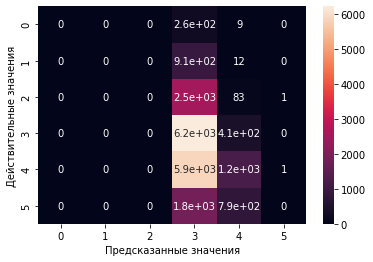

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       273
           1       0.00      0.00      0.00       920
           2       0.00      0.00      0.00      2619
           3       0.35      0.94      0.51      6634
           4       0.48      0.17      0.25      7071
           5       0.00      0.00      0.00      2641

    accuracy                           0.37     20158
   macro avg       0.14      0.18      0.13     20158
weighted avg       0.28      0.37      0.26     20158



In [50]:
gnb = GaussianNB(var_smoothing=7)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [51]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 1000, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

n_iterations: 7
n_required_iterations: 8
n_possible_iterations: 7
min_resources_: 60
max_resources_: 80631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2500
n_resources: 60
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
----------
iter: 1
n_candidates: 834
n_resources: 180
Fitting 5 folds for each of 834 candidates, totalling 4170 fits
----------
iter: 2
n_candidates: 278
n_resources: 540
Fitting 5 folds for each of 278 candidates, totalling 1390 fits
----------
iter: 3
n_candidates: 93
n_resources: 1620
Fitting 5 folds for each of 93 candidates, totalling 465 fits
----------
iter: 4
n_candidates: 31
n_resources: 4860
Fitting 5 folds for each of 31 candidates, totalling 155 fits
----------
iter: 5
n_candidates: 11
n_resources: 14580
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 6
n_candidates: 4
n_resources: 43740
Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'C': 61.22449918367347, 'tol': 10.

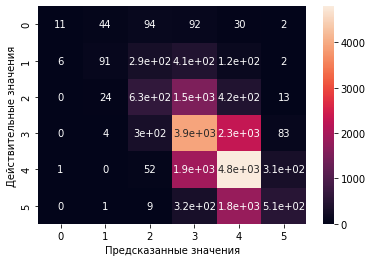

              precision    recall  f1-score   support

           0       0.61      0.04      0.08       273
           1       0.55      0.10      0.17       920
           2       0.46      0.24      0.32      2619
           3       0.48      0.59      0.53      6634
           4       0.51      0.68      0.58      7071
           5       0.56      0.19      0.29      2641

    accuracy                           0.49     20158
   macro avg       0.53      0.31      0.33     20158
weighted avg       0.50      0.49      0.47     20158



In [52]:
lr = LogisticRegression(C=122, tol=10, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [53]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, min_resources=50000, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

n_iterations: 1
n_required_iterations: 4
n_possible_iterations: 1
min_resources_: 50000
max_resources_: 80631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 29
n_resources: 50000
Fitting 5 folds for each of 29 candidates, totalling 145 fits
{'max_depth': 10} 0.4903792459245924


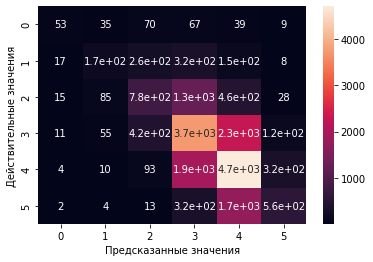

              precision    recall  f1-score   support

           0       0.52      0.19      0.28       273
           1       0.47      0.18      0.26       920
           2       0.48      0.30      0.37      2619
           3       0.49      0.56      0.52      6634
           4       0.50      0.67      0.57      7071
           5       0.54      0.21      0.30      2641

    accuracy                           0.50     20158
   macro avg       0.50      0.35      0.39     20158
weighted avg       0.50      0.50      0.48     20158



In [54]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [55]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 1000, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2986
max_resources_: 80631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 2986
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 10
n_resources: 8958
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 2
n_candidates: 4
n_resources: 26874
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 80622
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'max_depth': 11, 'n_estimators': 701} 0.5190086996321147


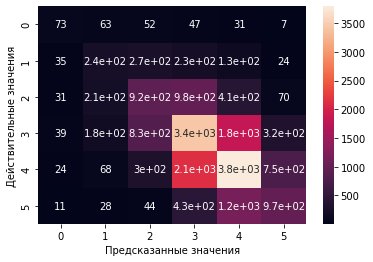

              precision    recall  f1-score   support

           0       0.34      0.27      0.30       273
           1       0.31      0.26      0.28       920
           2       0.38      0.35      0.37      2619
           3       0.47      0.52      0.49      6634
           4       0.52      0.54      0.53      7071
           5       0.45      0.37      0.41      2641

    accuracy                           0.47     20158
   macro avg       0.41      0.38      0.40     20158
weighted avg       0.46      0.47      0.47     20158



In [56]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [57]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2986
max_resources_: 80631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 2986
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 9
n_resources: 8958
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 26874
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 1
n_resources: 80622
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'leaf_size': 11, 'n_neighbors': 50} 0.4974882936313339


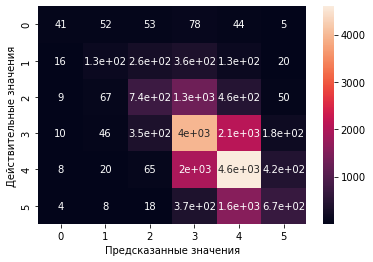

              precision    recall  f1-score   support

           0       0.47      0.15      0.23       273
           1       0.41      0.14      0.21       920
           2       0.50      0.28      0.36      2619
           3       0.49      0.60      0.54      6634
           4       0.52      0.65      0.58      7071
           5       0.50      0.25      0.34      2641

    accuracy                           0.50     20158
   macro avg       0.48      0.35      0.38     20158
weighted avg       0.50      0.50      0.48     20158



In [58]:
knc = KNeighborsClassifier(leaf_size=21, n_neighbors=60, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    SVC(),
    {
        "C": np.linspace(1e-3, 1000),
        "kernel": ["rbf", "poly", "linear", "sigmoid"],
        "tol": np.linspace(1e-3, 1000)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

n_iterations: 7
n_required_iterations: 9
n_possible_iterations: 7
min_resources_: 60
max_resources_: 80631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10000
n_resources: 60
Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
----------
iter: 1
n_candidates: 3334
n_resources: 180
Fitting 5 folds for each of 3334 candidates, totalling 16670 fits
----------
iter: 2
n_candidates: 1112
n_resources: 540
Fitting 5 folds for each of 1112 candidates, totalling 5560 fits
----------
iter: 3
n_candidates: 371
n_resources: 1620
Fitting 5 folds for each of 371 candidates, totalling 1855 fits


C:\Users\derbi\Projects\PyCharm\course-work\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


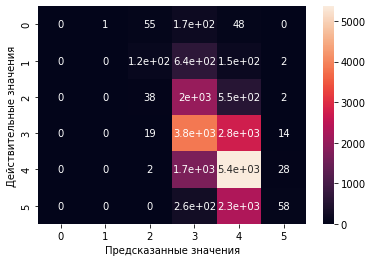

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       273
           1       0.00      0.00      0.00       920
           2       0.16      0.01      0.03      2619
           3       0.45      0.58      0.50      6634
           4       0.48      0.76      0.59      7071
           5       0.56      0.02      0.04      2641

    accuracy                           0.46     20158
   macro avg       0.27      0.23      0.19     20158
weighted avg       0.41      0.46      0.38     20158



In [51]:
svc = LinearSVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [[30] * 5, [30] * 10, [30] * 30],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

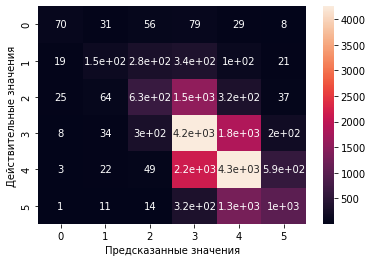

              precision    recall  f1-score   support

           0       0.56      0.26      0.35       273
           1       0.48      0.16      0.24       920
           2       0.48      0.24      0.32      2619
           3       0.49      0.64      0.55      6634
           4       0.54      0.60      0.57      7071
           5       0.54      0.38      0.45      2641

    accuracy                           0.51     20158
   macro avg       0.51      0.38      0.41     20158
weighted avg       0.51      0.51      0.50     20158



In [52]:
mlp = MLPClassifier(hidden_layer_sizes=[30] * 5, max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Модель тэгов

In [53]:
x = tags_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = tags_model_df.drop("user_id", axis=1)["rating"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler())
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [ ]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

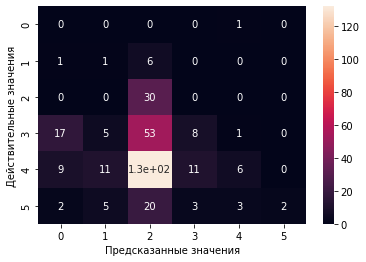

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.05      0.12      0.07         8
           2       0.12      1.00      0.22        30
           3       0.36      0.10      0.15        84
           4       0.55      0.04      0.07       169
           5       1.00      0.06      0.11        35

    accuracy                           0.14       327
   macro avg       0.35      0.22      0.10       327
weighted avg       0.49      0.14      0.11       327



In [54]:
gnb = GaussianNB(var_smoothing=6)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 1000, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

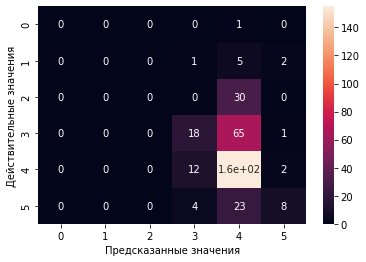

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.51      0.21      0.30        84
           4       0.56      0.92      0.69       169
           5       0.62      0.23      0.33        35

    accuracy                           0.55       327
   macro avg       0.28      0.23      0.22       327
weighted avg       0.49      0.55      0.47       327



In [55]:
lr = LogisticRegression(C=408, tol=27, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

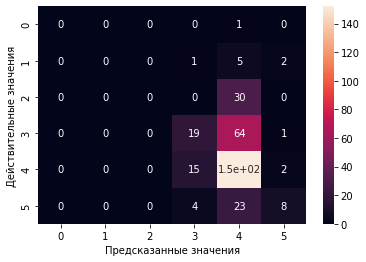

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.49      0.23      0.31        84
           4       0.55      0.90      0.68       169
           5       0.62      0.23      0.33        35

    accuracy                           0.55       327
   macro avg       0.28      0.23      0.22       327
weighted avg       0.48      0.55      0.47       327



In [56]:
dtc = DecisionTreeClassifier(max_depth=40)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 1000, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

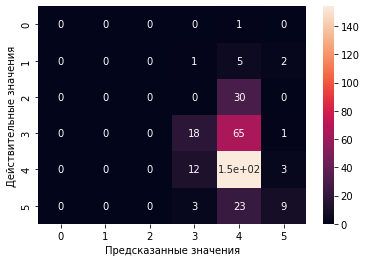

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.53      0.21      0.31        84
           4       0.55      0.91      0.69       169
           5       0.60      0.26      0.36        35

    accuracy                           0.55       327
   macro avg       0.28      0.23      0.23       327
weighted avg       0.49      0.55      0.47       327



In [57]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=401, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

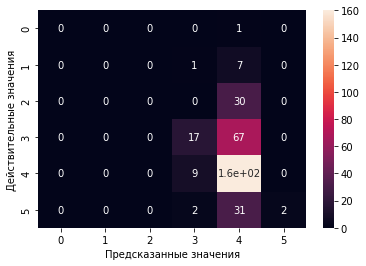

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.59      0.20      0.30        84
           4       0.54      0.95      0.69       169
           5       1.00      0.06      0.11        35

    accuracy                           0.55       327
   macro avg       0.35      0.20      0.18       327
weighted avg       0.54      0.55      0.44       327



In [58]:
knc = KNeighborsClassifier(leaf_size=21, n_neighbors=60, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    SVC(),
    {
        "C": np.linspace(1e-3, 1000),
        "kernel": ["rbf", "poly", "linear", "sigmoid"],
        "tol": np.linspace(1e-3, 1000)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

C:\Users\derbi\Projects\PyCharm\course-work\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


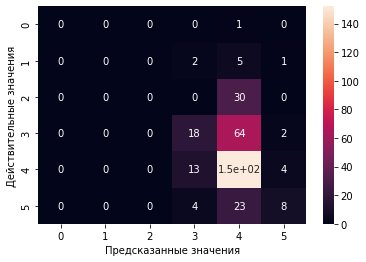

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.49      0.21      0.30        84
           4       0.55      0.90      0.68       169
           5       0.53      0.23      0.32        35

    accuracy                           0.54       327
   macro avg       0.26      0.22      0.22       327
weighted avg       0.47      0.54      0.46       327



In [59]:
svc = LinearSVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [(10,), (10, 10, 10), (40,), (40, 40, 40)],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

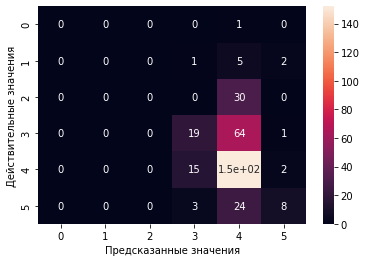

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.50      0.23      0.31        84
           4       0.55      0.90      0.68       169
           5       0.62      0.23      0.33        35

    accuracy                           0.55       327
   macro avg       0.28      0.23      0.22       327
weighted avg       0.48      0.55      0.47       327



In [60]:
mlp = MLPClassifier(hidden_layer_sizes=[30] * 5, max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Финальная модель

In [61]:
x = final_model_df.drop([
    "rating_genres", "rating_binary_genres", "rating_tags", "rating_binary_tags"
], axis=1)
y = final_model_df["rating_genres"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

genres_columns = list(
    genres_model_renamed_df.drop(["user_id_genres", "movie_id_genres", "rating_genres", "rating_binary_genres"],
                                 axis=1).columns)
tags_columns = list(
    tags_model_renamed_df.drop(["user_id_tags", "movie_id_tags", "rating_tags", "rating_binary_tags"], axis=1).columns)

genres_columns_nums = [genres_model_renamed_df.columns.get_loc(c) for c in genres_columns]
tags_columns_nums = [tags_model_renamed_df.columns.get_loc(c) for c in tags_columns]

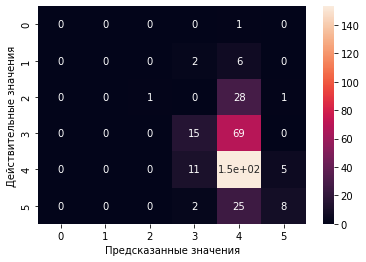

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       1.00      0.03      0.06        30
           3       0.50      0.18      0.26        84
           4       0.54      0.91      0.68       169
           5       0.57      0.23      0.33        35

    accuracy                           0.54       327
   macro avg       0.44      0.22      0.22       327
weighted avg       0.56      0.54      0.46       327



In [374]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=30, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

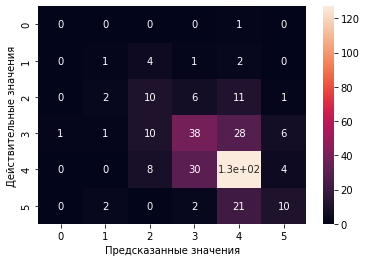

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.17      0.12      0.14         8
           2       0.31      0.33      0.32        30
           3       0.49      0.45      0.47        84
           4       0.67      0.75      0.71       169
           5       0.48      0.29      0.36        35

    accuracy                           0.57       327
   macro avg       0.35      0.32      0.33       327
weighted avg       0.56      0.57      0.56       327



In [375]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

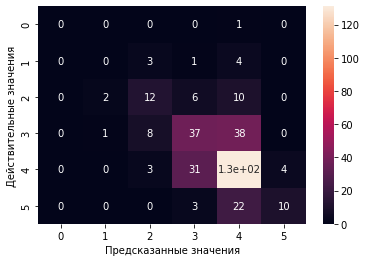

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.46      0.40      0.43        30
           3       0.47      0.44      0.46        84
           4       0.64      0.78      0.70       169
           5       0.71      0.29      0.41        35

    accuracy                           0.58       327
   macro avg       0.38      0.32      0.33       327
weighted avg       0.57      0.58      0.56       327



In [376]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=401, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

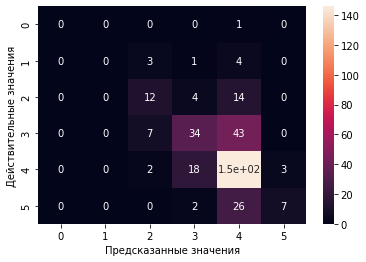

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.50      0.40      0.44        30
           3       0.58      0.40      0.48        84
           4       0.62      0.86      0.72       169
           5       0.70      0.20      0.31        35

    accuracy                           0.61       327
   macro avg       0.40      0.31      0.33       327
weighted avg       0.59      0.61      0.57       327



In [377]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", StackingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=50, n_jobs=cpu_count())),
        ("lr", LogisticRegression(max_iter=1e7, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=40, n_estimators=401, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=40))
    ],
        LogisticRegression(max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

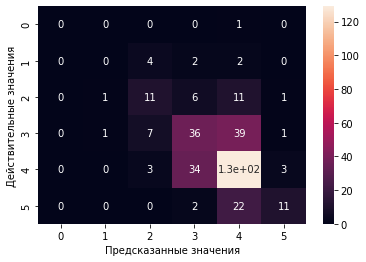

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.44      0.37      0.40        30
           3       0.45      0.43      0.44        84
           4       0.63      0.76      0.69       169
           5       0.69      0.31      0.43        35

    accuracy                           0.57       327
   macro avg       0.37      0.31      0.33       327
weighted avg       0.56      0.57      0.55       327



In [378]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", VotingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=60, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=40, n_estimators=401, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=40)),
        ("lr", LogisticRegression(max_iter=1e7, n_jobs=cpu_count()))
    ], voting="soft", n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

## Бинарные модели

### Модель жанров

In [128]:
x = genres_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = genres_model_df.drop("user_id", axis=1)["rating_binary"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler())
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [ ]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

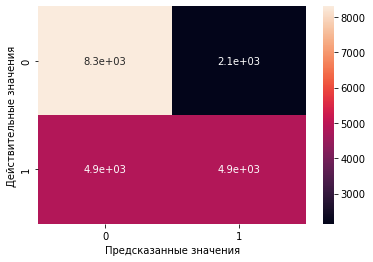

              precision    recall  f1-score   support

           0       0.63      0.79      0.70     10447
           1       0.69      0.50      0.58      9711

    accuracy                           0.65     20158
   macro avg       0.66      0.65      0.64     20158
weighted avg       0.66      0.65      0.64     20158



In [129]:
gnb = GaussianNB(var_smoothing=0.04)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 100, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

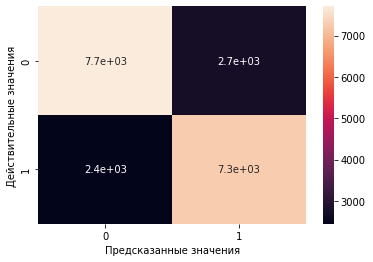

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     10447
           1       0.73      0.75      0.74      9711

    accuracy                           0.74     20158
   macro avg       0.74      0.74      0.74     20158
weighted avg       0.74      0.74      0.74     20158



In [130]:
lr = LogisticRegression(max_iter=1e7, C=78, tol=2, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, min_resources=50000, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

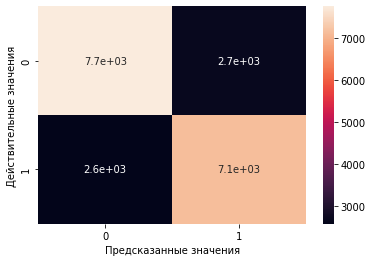

              precision    recall  f1-score   support

           0       0.75      0.74      0.75     10447
           1       0.73      0.73      0.73      9711

    accuracy                           0.74     20158
   macro avg       0.74      0.74      0.74     20158
weighted avg       0.74      0.74      0.74     20158



In [132]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 500, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

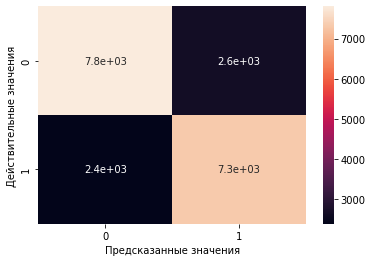

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     10447
           1       0.73      0.75      0.74      9711

    accuracy                           0.75     20158
   macro avg       0.75      0.75      0.75     20158
weighted avg       0.75      0.75      0.75     20158



In [139]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

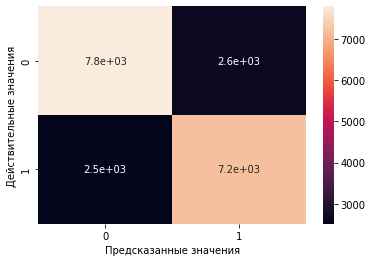

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     10447
           1       0.73      0.74      0.74      9711

    accuracy                           0.74     20158
   macro avg       0.74      0.74      0.74     20158
weighted avg       0.74      0.74      0.74     20158



In [67]:
knc = KNeighborsClassifier(leaf_size=11, n_neighbors=50, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

C:\Users\derbi\Projects\PyCharm\course-work\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


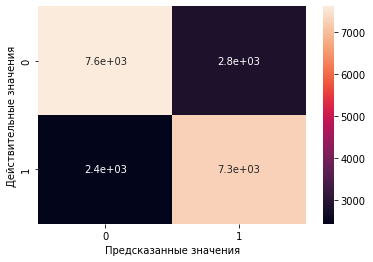

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     10447
           1       0.72      0.75      0.73      9711

    accuracy                           0.74     20158
   macro avg       0.74      0.74      0.74     20158
weighted avg       0.74      0.74      0.74     20158



In [68]:
svc = LinearSVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [(10,), (10, 10, 10), (40,), (40, 40, 40)],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

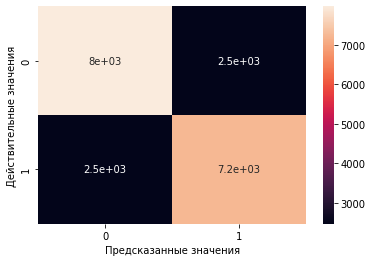

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     10447
           1       0.75      0.74      0.75      9711

    accuracy                           0.75     20158
   macro avg       0.75      0.75      0.75     20158
weighted avg       0.75      0.75      0.75     20158



In [140]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Модель тэгов

In [141]:
x = tags_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = tags_model_df.drop("user_id", axis=1)["rating_binary"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [ ]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

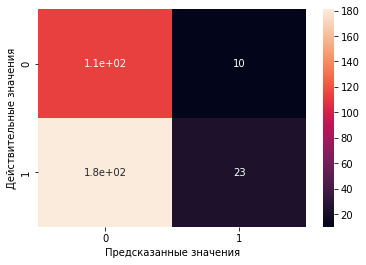

              precision    recall  f1-score   support

           0       0.38      0.92      0.54       123
           1       0.70      0.11      0.19       204

    accuracy                           0.42       327
   macro avg       0.54      0.52      0.37       327
weighted avg       0.58      0.42      0.32       327



In [142]:
gnb = GaussianNB(var_smoothing=0.04)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 100, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

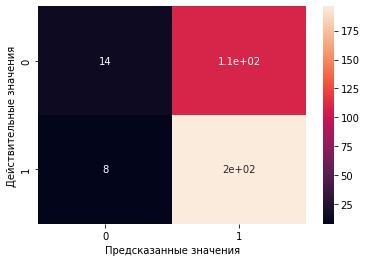

              precision    recall  f1-score   support

           0       0.64      0.11      0.19       123
           1       0.64      0.96      0.77       204

    accuracy                           0.64       327
   macro avg       0.64      0.54      0.48       327
weighted avg       0.64      0.64      0.55       327



In [147]:
lr = LogisticRegression(max_iter=1e7, C=78, tol=2, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, min_resources=50000, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

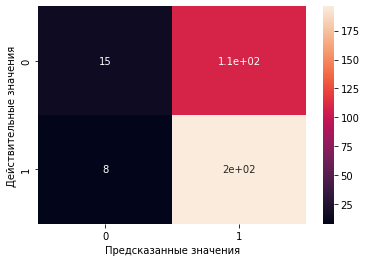

              precision    recall  f1-score   support

           0       0.65      0.12      0.21       123
           1       0.64      0.96      0.77       204

    accuracy                           0.65       327
   macro avg       0.65      0.54      0.49       327
weighted avg       0.65      0.65      0.56       327



In [146]:
dtc = DecisionTreeClassifier(max_depth=30)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 1000, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

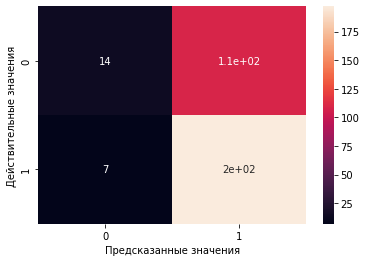

              precision    recall  f1-score   support

           0       0.67      0.11      0.19       123
           1       0.64      0.97      0.77       204

    accuracy                           0.65       327
   macro avg       0.66      0.54      0.48       327
weighted avg       0.65      0.65      0.56       327



In [145]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=401, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

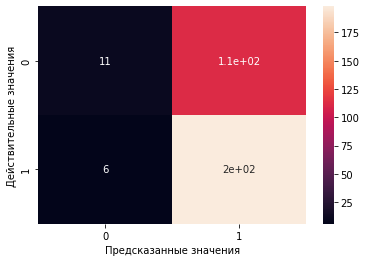

              precision    recall  f1-score   support

           0       0.65      0.09      0.16       123
           1       0.64      0.97      0.77       204

    accuracy                           0.64       327
   macro avg       0.64      0.53      0.46       327
weighted avg       0.64      0.64      0.54       327



In [75]:
knc = KNeighborsClassifier(leaf_size=21, n_neighbors=60, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    SVC(),
    {
        "C": np.linspace(1e-3, 1000),
        "kernel": ["rbf", "poly", "linear", "sigmoid"],
        "tol": np.linspace(1e-3, 1000)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

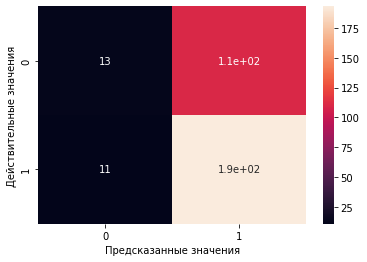

              precision    recall  f1-score   support

           0       0.54      0.11      0.18       123
           1       0.64      0.95      0.76       204

    accuracy                           0.63       327
   macro avg       0.59      0.53      0.47       327
weighted avg       0.60      0.63      0.54       327



In [76]:
svc = LinearSVC(max_iter=1e6)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [(10,), (10, 10, 10), (40,), (40, 40, 40)],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

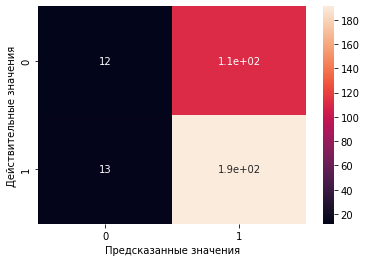

              precision    recall  f1-score   support

           0       0.48      0.10      0.16       123
           1       0.63      0.94      0.75       204

    accuracy                           0.62       327
   macro avg       0.56      0.52      0.46       327
weighted avg       0.58      0.62      0.53       327



In [77]:
mlp = MLPClassifier(hidden_layer_sizes=[30] * 5, max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Финальная модель

In [148]:
x = final_model_df.drop([
    "rating_genres", "rating_binary_genres", "rating_tags", "rating_binary_tags"
], axis=1)
y = final_model_df["rating_binary_tags"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

genres_columns = list(genres_model_renamed_df.drop(["user_id_genres", "movie_id_genres", "rating_genres", "rating_binary_genres"],
                                 axis=1).columns)
tags_columns = list(tags_model_renamed_df.drop(["user_id_tags", "movie_id_tags", "rating_tags", "rating_binary_tags"], axis=1).columns)

genres_columns_nums = [genres_model_renamed_df.columns.get_loc(c) for c in genres_columns]
tags_columns_nums = [tags_model_renamed_df.columns.get_loc(c) for c in tags_columns]

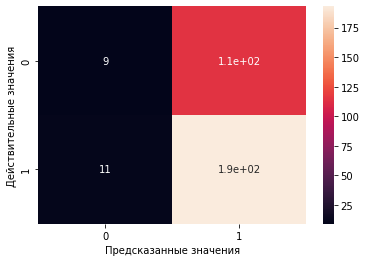

              precision    recall  f1-score   support

           0       0.45      0.07      0.13       123
           1       0.63      0.95      0.76       204

    accuracy                           0.62       327
   macro avg       0.54      0.51      0.44       327
weighted avg       0.56      0.62      0.52       327



In [149]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=30, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

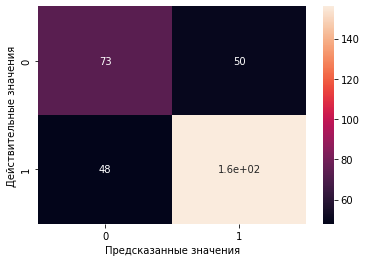

              precision    recall  f1-score   support

           0       0.60      0.59      0.60       123
           1       0.76      0.76      0.76       204

    accuracy                           0.70       327
   macro avg       0.68      0.68      0.68       327
weighted avg       0.70      0.70      0.70       327



In [154]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

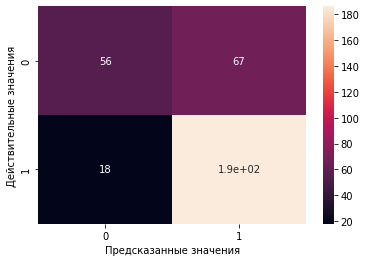

              precision    recall  f1-score   support

           0       0.76      0.46      0.57       123
           1       0.74      0.91      0.81       204

    accuracy                           0.74       327
   macro avg       0.75      0.68      0.69       327
weighted avg       0.74      0.74      0.72       327



In [155]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

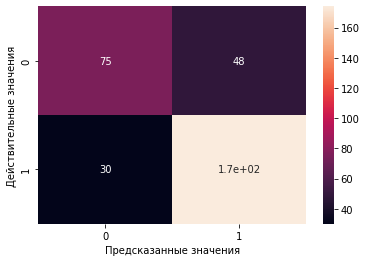

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       123
           1       0.78      0.85      0.82       204

    accuracy                           0.76       327
   macro avg       0.75      0.73      0.74       327
weighted avg       0.76      0.76      0.76       327



In [152]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", StackingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=50, n_jobs=cpu_count())),
        ("lr", LogisticRegression(max_iter=1e7, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=40, n_estimators=401, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=40))
    ],
        LogisticRegression(max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

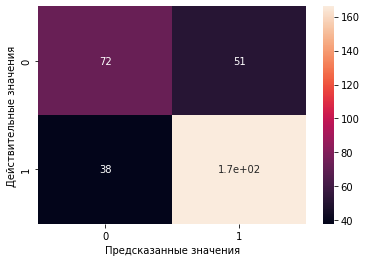

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       123
           1       0.76      0.81      0.79       204

    accuracy                           0.73       327
   macro avg       0.71      0.70      0.70       327
weighted avg       0.72      0.73      0.72       327



In [153]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", VotingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=60, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=40, n_estimators=401, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=40)),
        ("lr", LogisticRegression(max_iter=1e7, n_jobs=cpu_count()))
    ], voting="soft", n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)